In [152]:
import sys
sys.path.insert(0,'C:\\Users\\joclo\\Python_FE_CBS\\python_for_the_financial_economist-master\\python_for_the_financial_economist-master\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2
"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# plotting 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import animation, cm
import seaborn as sns

# working with time 
import datetime
# scipy for stat and optimization 
from scipy import stats
from scipy import optimize

# pandas data reader for downloading data
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
from scipy.linalg import block_diag


# for typehints 
from typing import Union, List

# cvxopt and cvxpy for optimization 
import cvxopt 
import cvxpy as cp 

"""
Own packages
"""

# nominal yield curve data
from codelib.dal.fred_yield_data import get_nominal_yield_data

# moments: kurtosis with probs, etc. 
from codelib.statistics import moments as mom

# functions for calculating risk budget and portfolio risk metrics 
from codelib.portfolio_optimization import risk_budget as rb 
from codelib.portfolio_optimization import risk_metrics as rm

from codelib.visualization.base import correlation_plot, risk_waterfall_chart, waterfall_chart

from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown, calculate_conditional_value_at_risk

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'sklearn'

**Question 1.3 Cheking simulated and analytical mean**

Simulated Mean: [1.0348034  1.06482509]
Analytical Mean: [1.03335677 1.07384965]

Simulated Covariance Matrix:
[[0.00627648 0.00292374]
 [0.00292374 0.02666559]]

Analytical Covariance Matrix:
[[0.005625 0.00225 ]
 [0.00225  0.0225  ]]


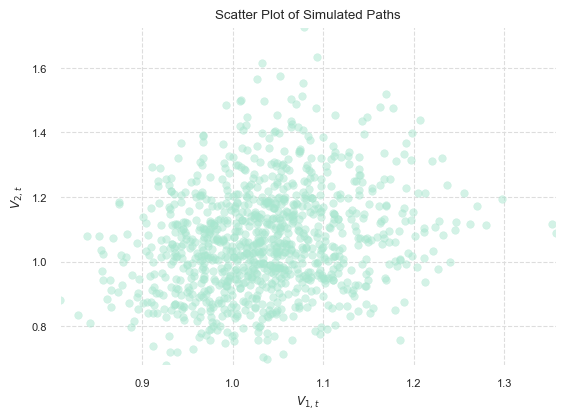

In [193]:
##Question 1.3 Cheking simulated and analytical mean 

np.random.seed(123)
mu1 = 0.03
mu2 = 0.06
sigma1 = 0.075
sigma2 = 0.15
rho = 0.2
initial_values = np.array([1.0, 1.0])
num_steps = 100   
num_paths = 1000
paths = np.zeros((num_paths, num_steps + 1, 2))

for i in range(num_paths):
    dt = 1 / num_steps
    dW1 = np.random.normal(0, np.sqrt(dt), num_steps)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), num_steps)

    paths[i, 0, :] = np.log(initial_values)

    for t in range(1, num_steps + 1):
        paths[i, t, 0] = paths[i, t - 1, 0] + (mu1 - 0.5 * sigma1**2) * dt + sigma1 * dW1[t - 1]
        paths[i, t, 1] = paths[i, t - 1, 1] + (mu2 - 0.5 * sigma2**2) * dt + sigma2 * dW2[t - 1]

# Transforming back to linear values
paths = np.exp(paths)

mean_simulated = np.mean(paths[:, -1, :], axis=0)
cov_matrix_simulated = np.cov(paths[:, -1, :], rowvar=False)

mean_analytical = np.array([np.exp(mu1 + (sigma1**2)/2), np.exp(mu2 + (sigma2**2)/2)])

cov_matrix_analytical = np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]])

print("Simulated Mean:", mean_simulated)
print("Analytical Mean:", mean_analytical)
print("\nSimulated Covariance Matrix:")
print(cov_matrix_simulated)
print("\nAnalytical Covariance Matrix:")
print(cov_matrix_analytical)

plt.scatter(paths[:, -1, 0], paths[:, -1, 1], alpha=0.5)
plt.title('Scatter Plot of Simulated Paths')
plt.xlabel('$V_{1,t}$')
plt.ylabel('$V_{2,t}$')
plt.show()


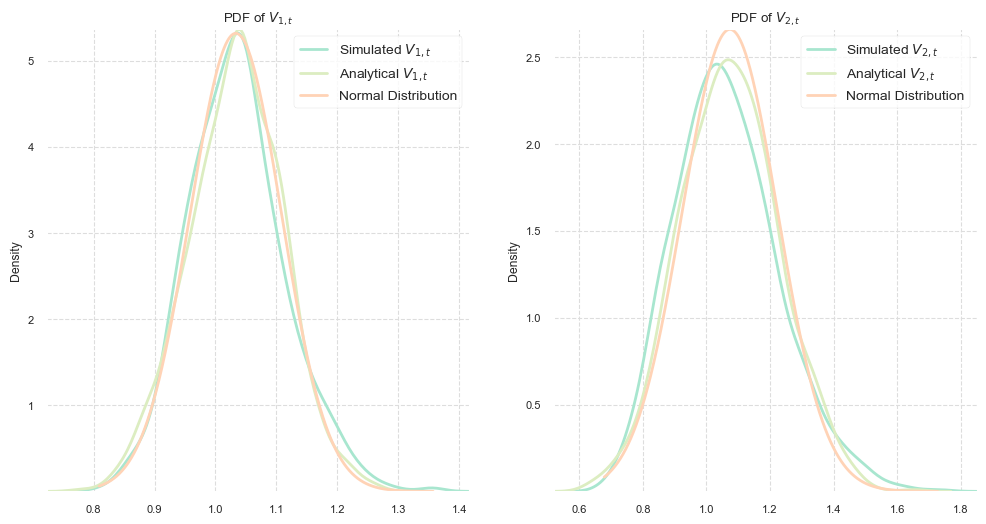

In [192]:
from scipy.stats import norm

def plot_and_compare(index, label, simulated_data, mean, std_dev, title):
    plt.subplot(1, 2, index)
    sns.kdeplot(simulated_data, label=f'Simulated ${label}$')
    sns.kdeplot(np.random.normal(mean, std_dev, 1000), label=f'Analytical ${label}$')
    plt.title(f'PDF of ${label}$')
    plt.legend()

    x = np.linspace(simulated_data.min(), simulated_data.max(), 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label='Normal Distribution')
    plt.legend(loc="upper right",fontsize=10)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot and compare for the first variable
plot_and_compare(1, 'V_{1,t}', paths[:, -1, 0], mean_analytical[0], np.sqrt(cov_matrix_analytical[0, 0]), f'PDF of $V_{1,t}$')

# Plot and compare for the second variable
plot_and_compare(2, 'V_{2,t}', paths[:, -1, 1], mean_analytical[1], np.sqrt(cov_matrix_analytical[1, 1]), f'PDF of $V_{2,t}$')

# Show the plot
plt.show()

In [116]:
#Question 1.4 estimating expected value and variance for BAH-strategy
np.random.seed(123)
mu1 = 0.03
mu2 = 0.06
sigma1 = 0.075
sigma2 = 0.15
rho = 0.2
initial_values = np.array([1.0, 1.0])
h = np.array([0.5, 0.5])  # portfolio holdings

# I choose 1,3,5yr investment horizons
horizons = [1, 3, 5]

for horizon in horizons:
    num_steps = 100 * horizon  
    num_paths = 1000
    paths = np.zeros((num_paths, num_steps + 1, 2))

    for i in range(num_paths):
        dt = 1 / num_steps
        dW1 = np.random.normal(0, np.sqrt(dt), num_steps)
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), num_steps)

        paths[i, 0, :] = np.log(initial_values)

        for t in range(1, num_steps + 1):
            paths[i, t, 0] = paths[i, t - 1, 0] + (mu1 - 0.5 * sigma1**2) * dt + sigma1 * dW1[t - 1]
            paths[i, t, 1] = paths[i, t - 1, 1] + (mu2 - 0.5 * sigma2**2) * dt + sigma2 * dW2[t - 1]

    # Transform back to linear 
    paths = np.exp(paths)

    # Calculate the portfolio values
    portfolio_values = np.dot(paths, h)

    mean_simulated = np.mean(portfolio_values[:, -1])
    var_simulated = np.var(portfolio_values[:, -1])

    print(f"For a {horizon}-year investment horizon:")
    print("Simulated Mean:", mean_simulated)
    print("Simulated Variance:", var_simulated)
    print("\n")


For a 1-year investment horizon:
Simulated Mean: 1.0498142465491518
Simulated Variance: 0.009687687465117147

For a 3-year investment horizon:
Simulated Mean: 1.0443090319406927
Simulated Variance: 0.009108515148154613

For a 5-year investment horizon:
Simulated Mean: 1.0475202374096766
Simulated Variance: 0.008782150771172509


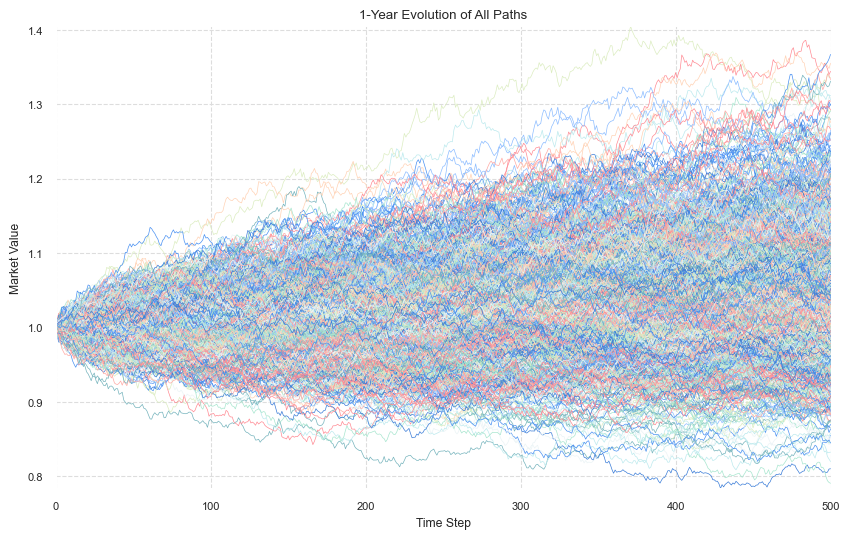

In [117]:
# Plot the 1-year evolution of all the paths
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(portfolio_values[i, :], linewidth=0.5)
plt.title('1-Year Evolution of All Paths')
plt.xlabel('Time Step')
plt.ylabel('Market Value')
plt.show()

In [ ]:
#######################################

**Montecarlo Simulatons like done in class**

In [153]:
#Defining simulation  funcion  
np.random.seed(123)
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat,
                                            size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [154]:
#SEt the parameters for the simulation of asset prices
np.random.seed(123)
mu1 = 0.03
mu2 = 0.06
sigma1 = 0.075
sigma2 = 0.15
rho = 0.2
initial_values = np.array([1.0, 1.0])
paths = np.zeros((num_paths, num_steps + 1, 2))


num_sim = 1000
mu=np.log(1+np.array([mu1,mu2]))
cov_mat= np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]])

dt = 1.0 # 1.0/12.0                     #Montly intervals
horizon = 5.0                           #Remeber to modify depending on the estimation !!!!

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_3  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_1 = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)



In [569]:
#Vizualising simulated asset prices
num_assets = len(mu)
time_points = np.arange(0.0, horizon + dt, dt)

#Vizualising assets
mean_prices = np.mean(asset_prices, axis=0)[:, :]
median_prices = np.median(asset_prices, axis=0)[:, :]
percentile_25 = np.percentile(asset_prices, 25, axis=0)[:, :]
percentile_75 = np.percentile(asset_prices, 75, axis=0)[:, :]

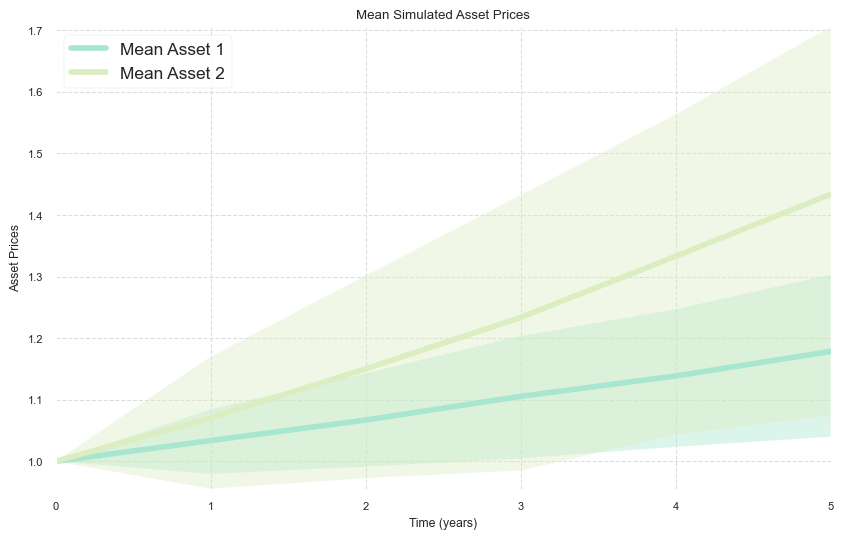

In [572]:
# Plotting
plt.figure(figsize=(10, 6),facecolor='white')

for asset in range(num_assets):
    plt.plot(time_points, mean_prices[:, asset], label=f'Mean Asset {asset+1}',linewidth=4, linestyle='-')
    plt.fill_between(time_points, percentile_25[:, asset], percentile_75[:, asset], alpha=0.4,linestyle='--')

plt.xlabel('Time (years)')
plt.ylabel('Asset Prices')
plt.title('Mean Simulated Asset Prices')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

**1.4 Estimateing the BAH portfolio in another way**

In [89]:
#printing the prices 
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

print(buy_and_hold_index)

[[1.         0.98815007 1.00388027 1.05665533 0.90449016 1.00336105]
 [1.         0.98392818 1.14998975 1.14200616 1.55632683 1.81649883]
 [1.         1.16558702 1.1726251  1.08503113 1.1599472  1.16653988]
 ...
 [1.         0.99742512 1.01943018 1.13528418 1.2971568  1.84143924]
 [1.         1.09340572 1.25580749 1.2054282  1.11795299 1.20397956]
 [1.         0.91731693 1.11450354 1.21174553 1.10468759 1.25068772]]


In [78]:
#Cumulative return over 5 years And the variance
buy_and_hold_expectation = np.mean(buy_and_hold_index, axis=0)[-1]  # Take the last time point
buy_and_hold_variance = np.var(buy_and_hold_index, axis=0)[-1]      # Take the last time point

print(f"Expectation (mean): {buy_and_hold_expectation}")
print(f"Variance: {buy_and_hold_variance}")


# Initial portfolio value (assuming it starts at 1.0)
initial_portfolio_value = 1.0

# Calculate and print the expected return for each year
for year in range(1, 6):
    final_portfolio_value_year = buy_and_hold_index[:, year]
    expected_return_year = np.mean(final_portfolio_value_year / initial_portfolio_value - 1)
    
    print(f"Expected Return after {years}: {expected_return_year}")


Expectation (mean): 1.306051729370824
Variance: 0.08041954421898732


NameError: name 'years' is not defined

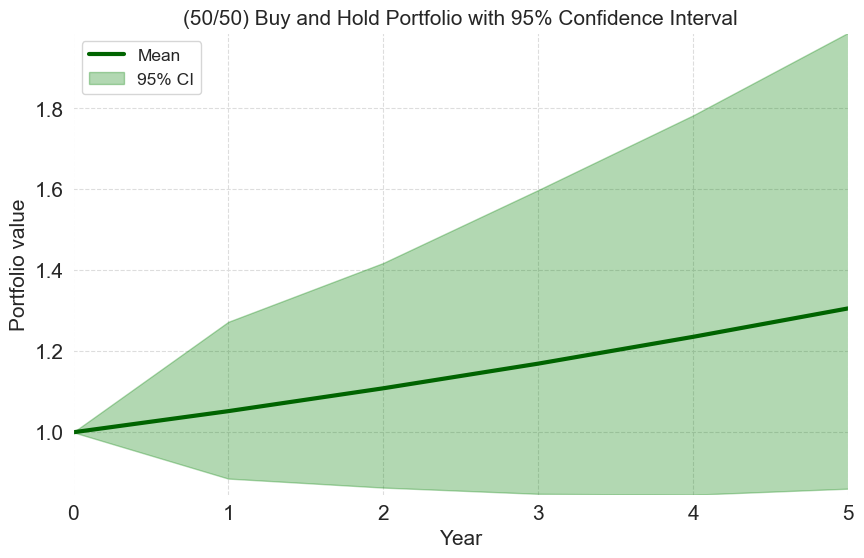

In [79]:
## Making plot of the buy and hold portfolio

# Create a line plot with shaded confidence interval
fig, ax = plt.subplots(figsize=(10, 6),facecolor='white')

sns.lineplot(x=time_points, y=buy_and_hold_index.mean(axis=0), color='darkgreen', label='Mean',linewidth=3, linestyle='-')
#sns.lineplot(x=time_points, y=percentile_95, color='red', label='95th Percentile')
ax.fill_between(time_points, np.percentile(buy_and_hold_index, 2.5, axis=0),
                np.percentile(buy_and_hold_index, 97.5, axis=0),
                color='green', alpha=0.3, label='95% CI')

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Portfolio value", size=15)
ax.set_title("(50/50) Buy and Hold Portfolio with 95% Confidence Interval", size=15)
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

**1.5 Estimating the constant-mix portfolio**

In [155]:
#Defining the function
np.random.seed()
"""
Constant mix porfolio (monthly rebalancing)
"""

def calculate_period_returns(index: np.ndarray) -> np.ndarray:
    
    """
    Calculates period returns
    
    Paramters
    ---------
    index: 
        Index values [num sim x num time steps x num_assets]. 
        
    Returns
    -------
    np.ndarray
        Period returns. 
    
    """
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index: np.ndarray, weights: np.ndarray) -> np.ndarray:
    
    """
    Calculates cum. return index of a constant mix strategy. 
    
    Parameters
    ----------
    index: 
        Index values  [num sim x num time steps x num_assets]. 
    weights: 
        Portfolio weights. 
        
    
    Returns
    -------
    np.ndarray
        Cum. return index [num sim x num time steps]. 
    
    """
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index

In [156]:
#Generating cumulative return for the constant mix  
np.random.seed(123)
constant_mix_index = calculate_constant_mix_index(asset_prices, port_w)
print("CM: ", constant_mix_index)
print("BAH: ", buy_and_hold_index)

CM:  [[1.         0.98815007 1.01311113 1.06611441 0.90204828 1.02988637]
 [1.         0.98392818 1.15407713 1.14565023 1.54921098 1.7875473 ]
 [1.         1.16558702 1.17276759 1.08103017 1.17627699 1.18308757]
 ...
 [1.         0.99742512 1.02012225 1.13610144 1.29492811 1.78648411]
 [1.         1.09340572 1.2558858  1.20567484 1.12235286 1.20999546]
 [1.         0.91731693 1.11451666 1.21139013 1.10973274 1.25596754]]
BAH:  [[1.         0.98815007 1.00388027 1.05665533 0.90449016 1.00336105]
 [1.         0.98392818 1.14998975 1.14200616 1.55632683 1.81649883]
 [1.         1.16558702 1.1726251  1.08503113 1.1599472  1.16653988]
 ...
 [1.         0.99742512 1.01943018 1.13528418 1.2971568  1.84143924]
 [1.         1.09340572 1.25580749 1.2054282  1.11795299 1.20397956]
 [1.         0.91731693 1.11450354 1.21174553 1.10468759 1.25068772]]


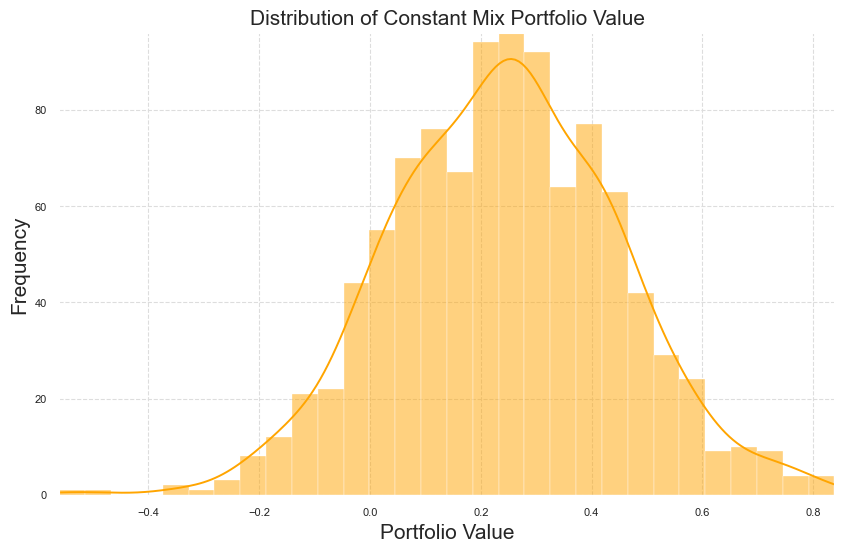

In [136]:
########## ploting distribution of the portfolio value vector when using constant mix strategy
# Flatten the constant mix index for each simulation and time point, i do this to get the cumulative returns for the last time step 
constant_mix_values = constant_mix_index[:, -1].flatten()
# Apply the logarithm to each value
log_constant_mix_values = np.log(constant_mix_values) #### Should be following a normal distribution
# Plot the distribution with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(log_constant_mix_values, bins=30, kde=True, color='orange')
plt.xlabel("Portfolio Value", size=15)
plt.ylabel("Frequency", size=15)
plt.title("Distribution of Constant Mix Portfolio Value", size=15)
plt.show()

In [131]:

## Checking the simulated expectation and  variance
mean_constant_mix = constant_mix_values.mean()
std_constant_mix = constant_mix_values.std()
#print(mean_constant_mix,std_constant_mix)

### Check the calculated values
# Constructing the mu vector
mu_theo= np.array([mu1, mu2])

# Calculate the expected value and variance based on the theoretical formulas
expected_value_theoretical = np.exp(np.dot(port_w, mu_theo) * constant_mix_index.shape[1])
variance_theoretical = np.exp(2 * np.dot(port_w, mu_theo) * constant_mix_index.shape[1]) * (np.exp(np.dot(port_w, cov_mat @ port_w) * constant_mix_index.shape[1]) - 1)

# Print the results
print("Simulated Expected Value:", mean_constant_mix)
print("Simulated Standard deviation:", std_constant_mix)
print("Theoretical Expected Value:", expected_value_theoretical)
print("Theoretical Standard deviation:", np.sqrt(variance_theoretical))

Simulated Expected Value: 1.1435042610416142
Simulated Standard deviation: 0.2048407551986559
Theoretical Expected Value: 1.3099644507332473
Theoretical Standard deviation: 0.2933697895625865


In [ ]:
# checking the percentiles og the simulated values agianst the theoretical 
# Calculate the simulated percentiles
simulated_percentiles = np.percentile(constant_mix_values, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],axis=0)

# Calculate the theoretical percentiles
theoretical_percentiles = np.percentile(np.exp(np.dot(port_w, mu) * constant_mix_index.shape[1] +
                                               np.sqrt(np.dot(port_w, cov_mat @ port_w) * constant_mix_index.shape[1]) *
                                               np.random.normal(size=constant_mix_values.shape)), 
                                          [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],axis=0)

# Print the results
print("Simulated Percentiles:", simulated_percentiles)
print("Theoretical Percentiles:", theoretical_percentiles)


In [ ]:
plt.plot(simulated_percentiles,theoretical_percentiles)
plt.title("Simulated vs Theoretical Percentiles")
plt.xlabel('Simulated Percentiles')
plt.ylabel('Theoretical Percentiles')
plt.show()

**1.6 Minimum variance optimizating**

In [112]:
############################################
# First i optimize for the BAH strategy
np.random.seed(123)
import numpy as np
from scipy.optimize import minimize

# Define the Sharpe ratio
def sharpe_ratio(weights, mu, cov_mat):
    port_return = weights @ mu
    port_vol = np.sqrt(weights @ cov_mat @ weights.T)
    return port_return / port_vol

# Initialize variables
num_assets = len(mu) 
investment_horizons = [1, 3, 5]  # investment horizons in years
num_simulations = 1000
# Calculate the best Sharpe ratio and weights for each investment horizon
for horizon in investment_horizons:
    num_periods = int(horizon / dt)
    log_returns = np.log(asset_prices[:, 1:num_periods+1, :] / asset_prices[:, :num_periods, :])
    mu = np.mean(log_returns, axis=(0, 1))
    cov_mat = np.cov(log_returns.reshape(-1, num_assets), rowvar=False)
    
    best_sharpe_ratio = -np.inf
    best_weights = None

    # Simulate weight combinations and calculate Sharpe ratios
    for _ in range(num_simulations):
        # Generate random weights and normalize them to sum to 1
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Calculate the Sharpe ratio for this weight combination
        sr = sharpe_ratio(weights, mu, cov_mat)
        
        # Update the best Sharpe ratio and weights if this one is better
        if sr > best_sharpe_ratio:
            best_sharpe_ratio = sr
            best_weights = weights

    print(f"Investment Horizon: {horizon} years")
    print(f"Best Sharpe Ratio: {best_sharpe_ratio}")
    print(f"Best Weights: {best_weights}\n")


Investment Horizon: 1 years
Best Sharpe Ratio: 0.50005086697544
Best Weights: [0.67107507 0.32892493]

Investment Horizon: 3 years
Best Sharpe Ratio: 0.5132698897186483
Best Weights: [0.68282322 0.31717678]

Investment Horizon: 5 years
Best Sharpe Ratio: 0.5128522359584333
Best Weights: [0.66264965 0.33735035]


C:\Users\joclo\AppData\Local\Temp\ipykernel_7192\2631292143.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


NameError: name 'max_sr_index' is not defined

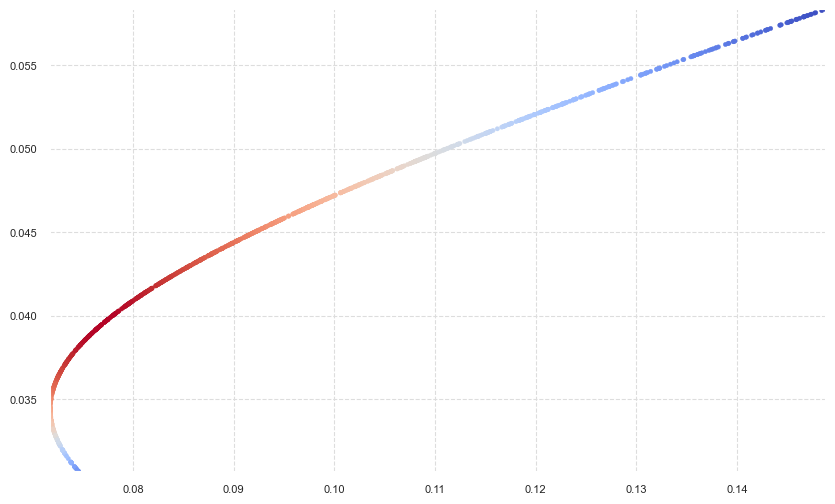

In [113]:
np.random.seed(123)
#Minimum variance plot for the BAH
investment_horizons = [3]  # investment horizons in years

# Plot the simulated portfolios for each investment horizon
for horizon in investment_horizons:
    num_periods = int(horizon / dt)
    log_returns = np.log(asset_prices[:, 1:num_periods+1, :] / asset_prices[:, :num_periods, :])
    mu = np.mean(log_returns, axis=(0, 1))
    cov_mat = np.cov(log_returns.reshape(-1, num_assets), rowvar=False)

    # Initialize arrays to store portfolio returns and volatilities
    port_returns = np.zeros(num_simulations)
    port_vol = np.zeros(num_simulations)

    # Simulate weight combinations and calculate portfolio returns and volatilities
    for i in range(num_simulations):
        # Generate random weights and normalize them to sum to 1
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        # Calculate the portfolio return and volatility for this weight combination
        port_returns[i] = weights @ mu
        port_vol[i] = np.sqrt(weights @ cov_mat @ weights.T)

    # Plot the simulated portfolios
    plt.style.use('seaborn-paper')
    plt.figure(figsize=(10, 6))
    plt.scatter(port_vol, port_returns, c=port_returns / port_vol, marker='o', cmap='coolwarm', s=10)
    plt.scatter(port_vol[max_sr_index], port_returns[max_sr_index], color='green', marker='.', s=500, label='Optimal portfolio')
    plt.title(f'Simulated Portfolios - {horizon}-year Horizon (Buy-And-Hold)')
    plt.xlabel('Portfolio Volatility (Variance)')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()



In [148]:
#Now i can check the CM... This code is definitly not correct.
## Optimizing the for the portfolio with the constant mix rebalancing
# Define the Sharpe ratio
def sharpe_ratio(weights, mu, cov_mat):
    port_return = weights @ mu
    port_vol = np.sqrt(weights @ cov_mat @ weights.T)
    return port_return / port_vol

# Initialize variables
num_simulations = 1000
investment_horizons = [1.0, 3.0, 5.0] 

# Calculate the best Sharpe ratio and weights for each investment horizon with constant rebalancing
for horizon in investment_horizons:
    num_periods = int(horizon / dt)
    log_returns = np.log(asset_prices[:, 1:num_periods + 1, :] / asset_prices[:, :num_periods, :])
    mu = np.mean(log_returns, axis=(0, 1))
    cov_mat = np.cov(log_returns.reshape(-1, num_assets), rowvar=False)

    # Initialize arrays to store portfolio returns and volatilities
    port_returns = np.zeros(num_simulations)
    port_vol = np.zeros(num_simulations)

    # Simulate weight combinations and calculate portfolio returns and volatilities with constant rebalancing
    for i in range(num_simulations):
        # Generate random weights and normalize them to sum to 1
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        # Calculate the Sharpe ratio for this weight combination
        sr = sharpe_ratio(weights, mu, cov_mat)
        port_returns[i] = weights @ mu
        port_vol[i] = np.sqrt(weights @ cov_mat @ weights.T)

        # Rebalance weights to the initial allocation
        weights = np.ones(num_assets) / num_assets

    # Find the portfolio with the maximum Sharpe ratio
    max_sr_index = np.argmax(port_returns / port_vol)
    best_sharpe_ratio = port_returns[max_sr_index] / port_vol[max_sr_index]
    best_weights = np.ones(num_assets) / num_assets  # Initial weights for constant rebalancing

    print(f"Investment Horizon: {horizon} years (Constant Rebalancing)")
    print(f"Best Sharpe Ratio: {best_sharpe_ratio}")
    print(f"Best Weights: {best_weights}\n")

Investment Horizon: 1.0 years (Constant Rebalancing)
Best Sharpe Ratio: 0.50005086697544
Best Weights: [0.5 0.5]

Investment Horizon: 3.0 years (Constant Rebalancing)
Best Sharpe Ratio: 0.5132698897186483
Best Weights: [0.5 0.5]

Investment Horizon: 5.0 years (Constant Rebalancing)
Best Sharpe Ratio: 0.5128522359584333
Best Weights: [0.5 0.5]


In [149]:
np.random.seed(123)
##Making a plot for the 3 year horizon of the constant rebalanciing 
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the Sharpe ratio
def sharpe_ratio(weights, mu, cov_mat):
    port_return = weights @ mu
    port_vol = np.sqrt(weights @ cov_mat @ weights.T)
    return port_return / port_vol

# Initialize variables
num_simulations = 1000
horizon = 1.0  # investment horizon in years
num_periods = int(horizon / dt)

# Calculate the best Sharpe ratio and weights for the three-year horizon with constant rebalancing
log_returns = np.log(asset_prices[:, 1:num_periods + 1, :] / asset_prices[:, :num_periods, :])
mu = np.mean(log_returns, axis=(0, 1))
cov_mat = np.cov(log_returns.reshape(-1, num_assets), rowvar=False)

# Initialize arrays to store portfolio returns and volatilities
port_returns = np.zeros(num_simulations)
port_vol = np.zeros(num_simulations)

# Simulate weight combinations and calculate portfolio returns and volatilities with constant rebalancing
for i in range(num_simulations):
    # Generate random weights and normalize them to sum to 1
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    # Calculate the Sharpe ratio for this weight combination
    sr = sharpe_ratio(weights, mu, cov_mat)
    port_returns[i] = weights @ mu
    port_vol[i] = np.sqrt(weights @ cov_mat @ weights.T)

    # Rebalance weights to the initial allocation
    weights = np.ones(num_assets) / num_assets

# Find the portfolio with the maximum Sharpe ratio
max_sr_index = np.argmax(port_returns / port_vol)
best_sharpe_ratio = port_returns[max_sr_index] / port_vol[max_sr_index]
best_weights = np.ones(num_assets) / num_assets  # Initial weights for constant rebalancing


C:\Users\joclo\AppData\Local\Temp\ipykernel_7192\205533773.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


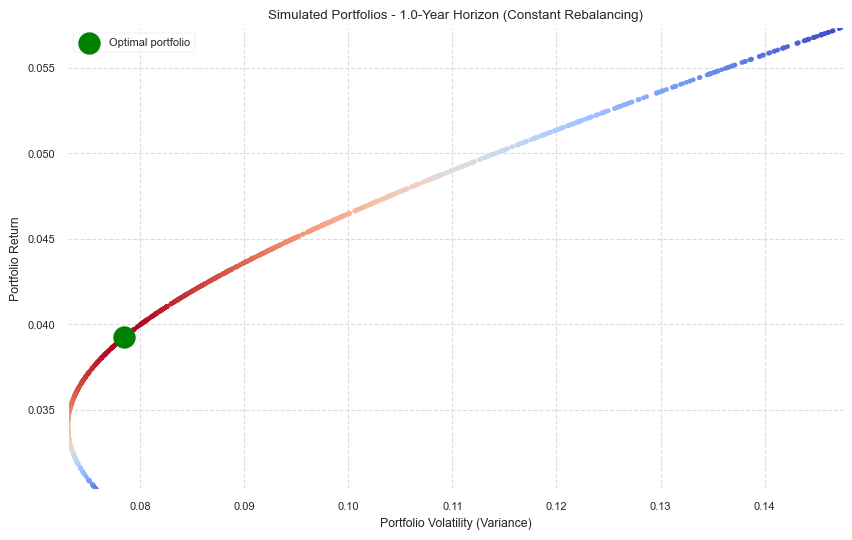

In [150]:
plt.style.use('seaborn-paper')
# Plot the simulated portfolios for the three-year horizon with constant rebalancing
plt.figure(figsize=(10, 6))
plt.scatter(port_vol, port_returns, c=port_returns / port_vol, marker='o', cmap='coolwarm',s=10)
plt.scatter(port_vol[max_sr_index], port_returns[max_sr_index], color='green', marker='.', s=1000, label='Optimal portfolio')
plt.title(f'Simulated Portfolios - {horizon}-Year Horizon (Constant Rebalancing)')
plt.xlabel('Portfolio Volatility (Variance)')
plt.ylabel('Portfolio Return')
#plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.show()

**1.7 optimization with target value**

In [178]:
######Optimizing for the constant mix. Variance is the opjective 
np.random.seed(123)

def objective_function(x, cov_mat):
    return -portfolio_variance(x, cov_mat)


# define common constraints
sum_to_one_cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}
no_short_cons = {'type': 'ineq', 'fun': lambda x: x}

# alternatively use
bounds = [(0.0, 1.0)] * 2

def target_return_constraint(x, target, asset_prices):
    return np.mean(calculate_constant_mix_index(asset_prices, x)[:, -1]) - target

port_weights = list()
targets = [1.15, 1.20, 1.27, 1.284, 1.29, 1.33, 1.40]

for target in targets:
    print(target)

    # define constraint
    target_cons = {'type': 'eq', 'fun': lambda x: target_return_constraint(x, target, asset_prices)}

    x0 = np.ones(2) / 2.0
    res = optimize.minimize(objective_function, x0=x0, args=(cov_mat,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, target_cons],
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x)

port_weights = np.array(port_weights)

1.15
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.005625
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 2
1.2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0052066537636961735
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
1.27
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0064454122895408125
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
1.284
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0071375356525955405
            Iterations: 3
            Function evaluations: 10
            Gradient evaluations: 3
1.29
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.007476840779797043
            Iterati

**Optimizing CM over the CVAR to see if there is a big difference from the minimum variance**

In [ ]:
#Costant mix rebalancing minimum variance with target value 
np.random.seed(123)
def objective_function(x, index, beta):

    constant_mix_index = calculate_constant_mix_index(index, x)[:, -1]

    return -calculate_conditional_value_at_risk(constant_mix_index, p = 1.0 - beta)

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 2 #+ [(None, None)]


def target_return_constraint(x, target, asset_prices):

    return np.mean(calculate_constant_mix_index(asset_prices, x)[:, -1]) - target

port_weights = list()
targets = [1.15, 1.20, 1.27, 1.284, 1.29, 1.33, 1.40]
for target in targets:
    
    print(target)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: target_return_constraint(x, target, asset_prices)}


    x0 = np.r_[np.ones(2) / 2.0]
    res = optimize.minimize(portfolio_variance, x0=x0, args=(asset_prices, 0.95),
                            method='SLSQP',
                            constraints=[sum_to_one_cons,  target_cons], 
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x) #[:-1])
    
    
port_weights_CM_CVAR = np.array(port_weights)

**very similare weights -> Continuing with the minimum VAR code**

In [170]:
port_weights

array([[1.        , 0.        ],
       [0.9091081 , 0.0908919 ],
       [0.62233526, 0.37766474],
       [0.56657301, 0.43342699],
       [0.54282939, 0.45717061],
       [0.3868327 , 0.6131673 ],
       [0.12288447, 0.87711553]])

In [179]:
# Find the index corresponding to the target return of 1.284
target_index = targets.index(1.284)

def portfolio_variance(w, cov_mat):
    return w @ cov_mat @ w.T

# Extract optimal weights, variance, and st.dev for the target return of 1.284
optimal_weights_CM_1_284 = port_weights[target_index]
portfolio_values_CM_1_284 = (asset_prices @ optimal_weights_CM_1_284)[:, -1]
variance_CM_1_284 = portfolio_variance(optimal_weights_CM_1_284, cov_mat)
stdev_CM_1_284 = np.sqrt(variance_CM_1_284)

# Calculate VaR and CVaR at the 5% level
value_at_risk_CM_1_284 = np.percentile(portfolio_values_CM_1_284, 5)
cond_value_at_risk_CM_1_284 = np.mean(portfolio_values_CM_1_284[portfolio_values_CM_1_284 <= value_at_risk_CM_1_284])

# Print the results
print("Optimal Weights for Target Return 1.284:", optimal_weights_CM_1_284)
print("Variance for Target Return 1.284:", variance_CM_1_284)
print("Standard Deviation for Target Return 1.284:", stdev_CM_1_284)
print("Value at Risk (VaR) at 5% for Target Return 1.284:", value_at_risk_CM_1_284)
print("Conditional Value at Risk (CVaR) at 5% for Target Return 1.284:", cond_value_at_risk_CM_1_284)

Optimal Weights for Target Return 1.284: [0.56657301 0.43342699]
Variance for Target Return 1.284: 0.0071375356525955405
Standard Deviation for Target Return 1.284: 0.08448393724605607
Value at Risk (VaR) at 5% for Target Return 1.284: 0.9321322713011653
Conditional Value at Risk (CVaR) at 5% for Target Return 1.284: 0.8499405354869707


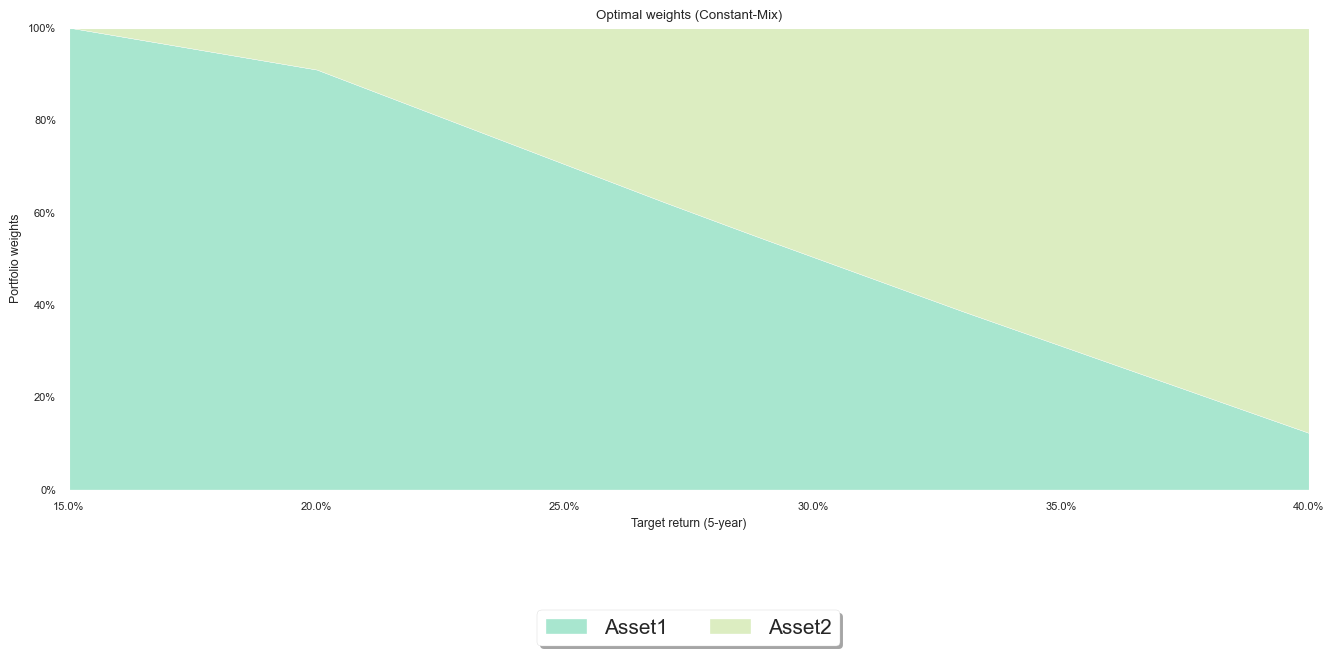

In [173]:
#Plot of weights 
import matplotlib.ticker as ticker
asset_list = ["Asset1", "Asset2"] 

fig, ax = plt.subplots(figsize=(16, 6))

# Assuming 'port_weights' is defined from your optimization code
ax.stackplot(np.array(targets) - 1.0, port_weights.T, labels=asset_list)

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6)
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights (Constant-Mix)")

plt.show()


**Optimzing the BAH rebalancing with target is done below**

In [174]:
## Tried estimating with the variance, but no sure i am getting the correct weights.
#### I am therefore suplementing with the VAR code used in class.
#Simulating the BAH rebalancing with a target return
np.random.seed(123)

def portfolio_variance(w, cov_mat):
    return w @ cov_mat @ w.T
horizon = 5.0
port_weights = list()
targets = [1.15, 1.20, 1.27, 1.284, 1.29, 1.33, 1.40]

num_resamples = 50
size_resample = 1000
optimal_weights_buy_and_hold = np.zeros((len(targets), 2))

for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:
        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: np.mean((asset_prices_sim @ x)[:, -1]) - target}

        x0 = np.r_[np.ones(2) / 2.0]
        res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                       method='SLSQP',
                       constraints=[sum_to_one_cons,  target_cons], 
                       options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)

    optimal_weights_buy_and_hold += np.array(opt_port_w_sim) / num_resamples
    
optimal_weights_buy_and_hold = np.array(optimal_weights_buy_and_hold)

optimal_weights_buy_and_hold

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


array([[1.        , 0.        ],
       [0.91487781, 0.08512219],
       [0.63975913, 0.36024087],
       [0.58473539, 0.41526461],
       [0.56115379, 0.43884621],
       [0.40394311, 0.59605689],
       [0.12882443, 0.87117557]])

**Optimizing BH over the CVAR to see if there is a big difference from the minimum variance**

In [93]:
####Estimating with CVAR
np.random.seed(123)
def objective_function_buy_and_hold(w, index, beta):

    buy_and_hold_index = (index @ w)[:, -1]

    return -calculate_conditional_value_at_risk(buy_and_hold_index, p = 1.0 - beta)

port_weights = list()
targets = [1.15, 1.20, 1.27, 1.284, 1.29, 1.33, 1.40]

num_resamples = 50
size_resample = 1000
optimal_port_resampled_weights_buy_and_hold = np.zeros((len(targets), 2))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: np.mean((asset_prices_sim @ x)[:, -1]) - target}


        x0 = np.r_[np.ones(2) / 2.0]
        res = optimize.minimize(objective_function_buy_and_hold, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)


    optimal_port_resampled_weights_buy_and_hold += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights_buy_and_hold = np.array(optimal_port_resampled_weights_buy_and_hold)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [175]:
optimal_port_resampled_weights_buy_and_hold 


array([[1.        , 0.        ],
       [0.91487781, 0.08512219],
       [0.63975913, 0.36024087],
       [0.58473539, 0.41526461],
       [0.56115379, 0.43884621],
       [0.40394311, 0.59605689],
       [0.12882443, 0.87117557]])

In [99]:
optimal_weights_buy_and_hold  

array([[1.        , 0.        ],
       [0.91487781, 0.08512219],
       [0.63975913, 0.36024087],
       [0.58473539, 0.41526461],
       [0.56115379, 0.43884621],
       [0.40394311, 0.59605689],
       [0.12882443, 0.87117557]])

**Both methodes generate the same portfolio values even though the on has objective CVAR and the other has variance**

**1.8 Comparing the optimal portfolio for the two rebalancing strategies**

In [181]:
######5% Value at risk for the BH portfolio
# Find the index corresponding to the target return of 1.284
target_index = targets.index(1.284)

# Extract optimal weights, variance, and st.dev for the target return of 1.284
optimal_weights_BH_1_284 = optimal_weights_buy_and_hold[target_index]
portfolio_values_BH_1_284 = (asset_prices @ optimal_weights_BH_1_284)[:, -1]
variance_BH_1_284 = portfolio_variance(optimal_weights_BH_1_284, cov_mat)
stdev_BH_1_284 = np.sqrt(variance_BH_1_284)

# Calculate VaR and CVaR at the 5% level
value_at_risk_BH_1_284 = np.percentile(portfolio_values_BH_1_284, 5)
cond_value_at_risk_BH_1_284 = np.mean(portfolio_values_BH_1_284[portfolio_values_BH_1_284 <= value_at_risk_BH_1_284])


# Print the results
print("Optimal Weights for Target Return 1.284:", optimal_weights_BH_1_284)
print("Variance for Target Return 1.284:", variance_BH_1_284)
print("Standard Deviation for Target Return 1.284:", stdev_BH_1_284)
print("Value at Risk (VaR) at 5% for Target Return 1.284:", value_at_risk_BH_1_284)
print("Conditional Value at Risk (CVaR) at 5% for Target Return 1.284:", cond_value_at_risk_BH_1_284)

Optimal Weights for Target Return 1.284: [0.58473539 0.41526461]
Variance for Target Return 1.284: 0.006895969826016606
Standard Deviation for Target Return 1.284: 0.08304197628920332
Value at Risk (VaR) at 5% for Target Return 1.284: 0.9328484818282665
Conditional Value at Risk (CVaR) at 5% for Target Return 1.284: 0.8525100383094992


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


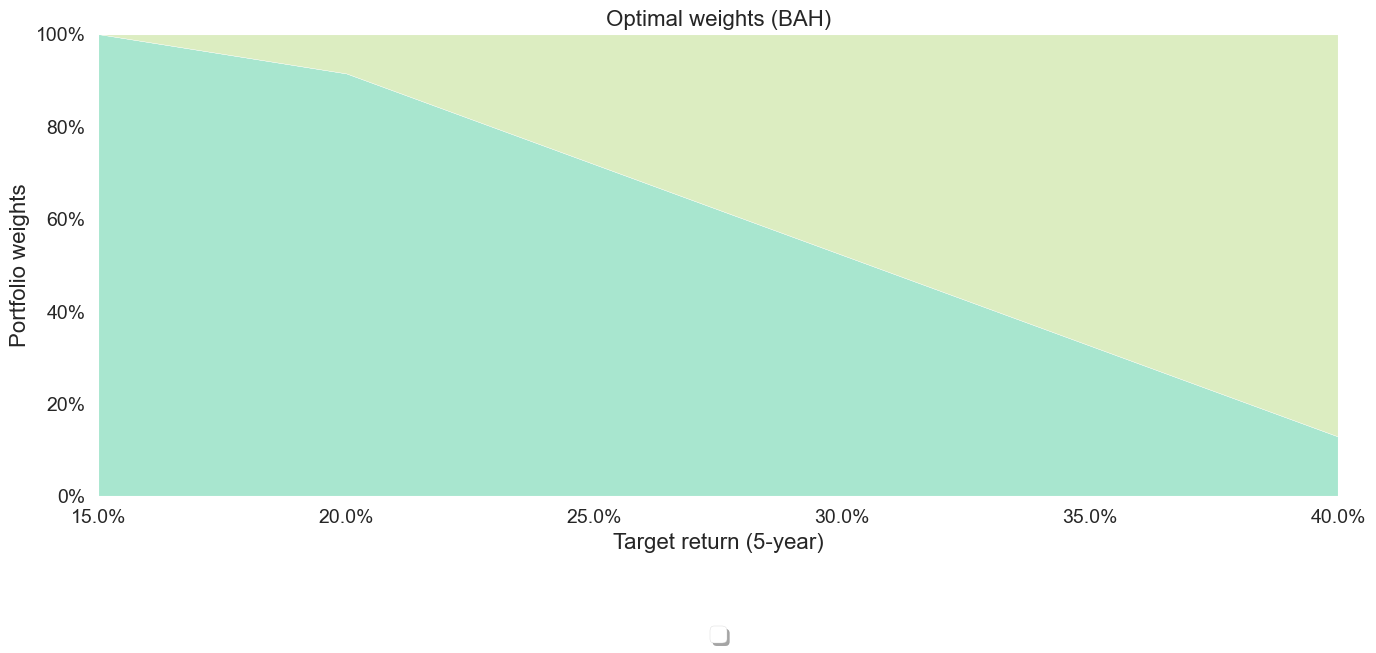

In [176]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.stackplot(np.array(targets) - 1.0, optimal_weights_buy_and_hold.T);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.tick_params(axis='both', labelsize=14)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)",fontsize=16)
ax.set_ylabel("Portfolio weights",fontsize=16)
ax.set_title("Optimal weights (BAH)",fontsize=16); 

**Above i have the results for the BAH rebalancing when there is a target return**

In [184]:
#Think this is the best way to estimate VAR and CVAR
target_index = targets.index(1.284)
optimal_weights_BH_1_284 = optimal_port_resampled_weights_buy_and_hold[target_index]
##Calculating CVAR for the constant mix
for i in range(len(targets)):
    
    index_vals_BH = (asset_prices @ optimal_weights_CM_1_284)[:, -1]
    value_at_risk_BH = np.percentile(index_vals_BH, 5)
    cond_value_at_risk_BH = np.mean(index_vals_BH[index_vals_BH <= value_at_risk_BH])
    print("CVaR(5%) for target = {}: ".format(target_index))
    print(cond_value_at_risk_BH)
    print('VAR:', value_at_risk_BH)
    print("\n")

CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


CVaR(5%) for target = 3: 
0.8499405354869707
VAR: 0.9321322713011653


In [185]:
#Think this is the best way to estimate VAR and CVAR
target_index = targets.index(1.284)
optimal_weights_CM_1_284 = port_weights[target_index]
##Calculating CVAR for the constant mix
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, optimal_weights_CM_1_284)[:, -1]
    value_at_risk_CM = np.percentile(index_vals, 5)
    cond_value_at_risk_CM = np.mean(index_vals[index_vals <= value_at_risk_CM])
    print("CVaR(5%) for target = {}: ".format(target_index))
    print(cond_value_at_risk)
    print('VAR:', value_at_risk_CM)
    print("\n")


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


CVaR(5%) for target = 3: 
0.7925015126485113
VAR: 0.9272174824623406


In [53]:
#Get different reults now, however this checks that the weights are the same. not sure what i am doing differently
target_index = targets.index(1.284)
optimal_weights_CM_1_284 = port_weights[target_index]
optimal_weights_CM_1_284

array([0.56657301, 0.43342699])

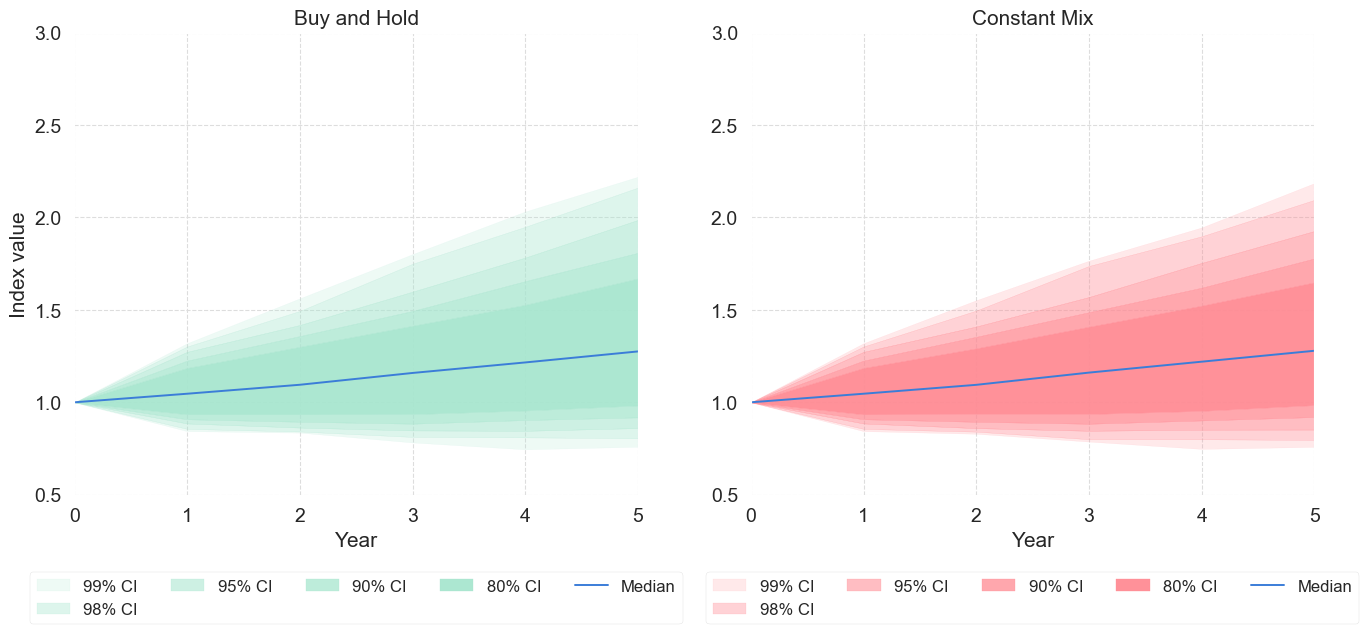

In [147]:
#Comparing the two strategies withe a fan plot 
time_points = np.arange(0.0, horizon + 0.01, dt)

# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index,
                                         [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_constant_mix = np.percentile(constant_mix_index, 
                                         [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['green'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].tick_params(axis='both', labelsize=14)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].tick_params(axis='both', labelsize=14)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);